In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook


## Original Organics formulation

In [2]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [3]:
U,V = np.linalg.eig(Wyy)

<IPython.core.display.Javascript object>


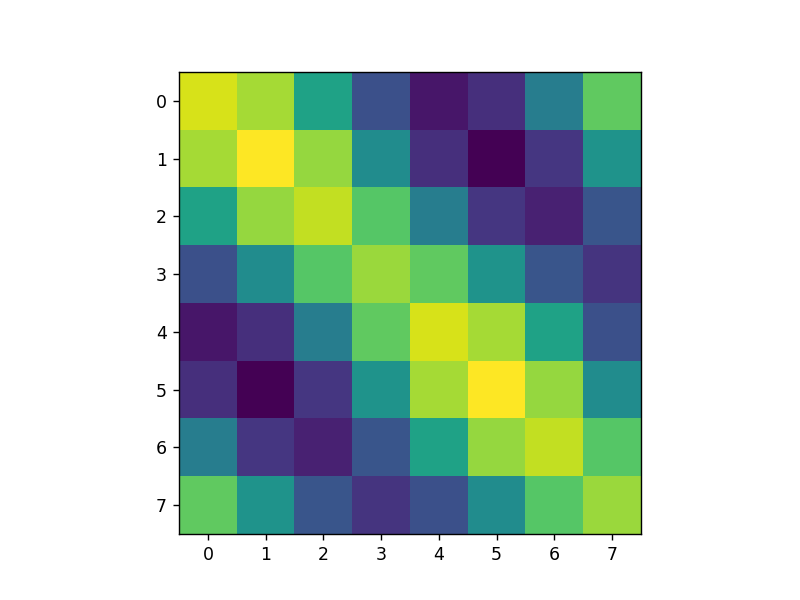

In [4]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [5]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [6]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

<IPython.core.display.Javascript object>


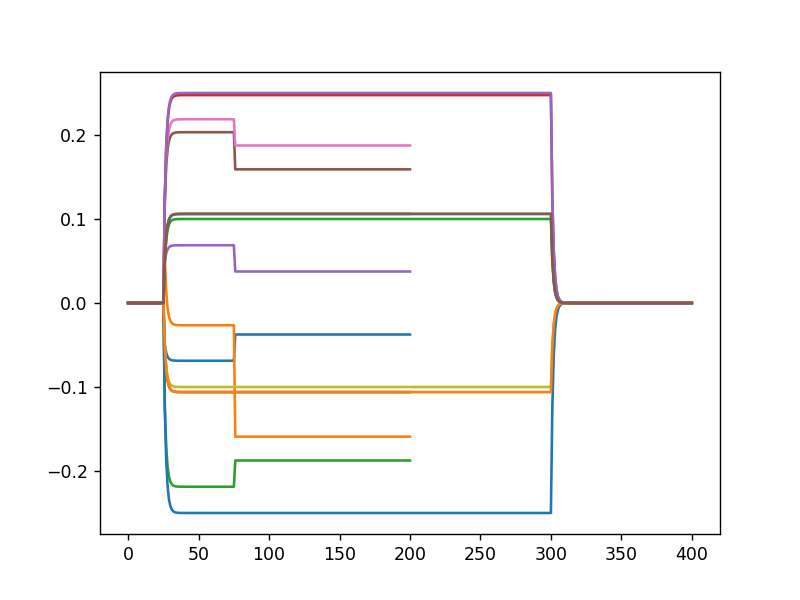

In [7]:
# Plot of Y traces!
plt.figure()
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [8]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

In [9]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [10]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 0.1}

In [11]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def start_simulation(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * Iref: initial reference current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        * aI: gating variable for I
        * ay: gating variable for y
        * aR: gating variable for Iref
        * z: initial state of z
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    aI_lst, ay_lst, aR_lst: list of gating variables at each instant
    I_lst: list of I activities
    Iref: final reference current state
        
    '''
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    
    
    # Unpack variables
    I, u, v, y, sig, aI, ay, aR, z = state_init
    
    aI_target = sig
    ay_target = 1 - sig
    aR_target = 1 - sig
    
    
    u_lst = []
    v_lst = []
    y_lst = []
    aI_lst = []
    ay_lst = []
    aR_lst = []
    I_lst = []
    z_lst = []
    
    for i in range(niter):
        # Update of gating variables
        aI += (-aI + aI_target) / 10 * dt
        ay += (-ay + ay_target) / 10 * dt
        aR += (-aR + aR_target) / 10 * dt
        
        # I update here:
        I += (aI * K * z) / tau * dt

        # u-v and y update
        u += (-u + ay * thresh_exp(Wut * I - Wuv * v + ext) + (1 - ay) * 0.7) / tau * dt
        v += (-v + ay * thresh_exp(Wvt * I - Wvu * u + ext) + (1 - ay) * 0.2) / tau * dt
        y += (-y + ay * (u - v) + (1 - ay) * y) / tau * dt
        z += (-z + y - y0) / tau * dt

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        aI_lst.append(aI)
        ay_lst.append(ay)
        aR_lst.append(aR)
        I_lst.append(I)
        z_lst.append(z)
        
    return u_lst, v_lst, y_lst, aI_lst, ay_lst, aR_lst, I_lst, z_lst

At a high level, the simulation alternates between two states which is encoded by a variable `s`
* When `s = 0`, the network operates in *integration* mode
    - Neurons `u` and `v` start at the reset point and mutually inhibit each other
    - `y = u - v` exhibits a ramp
    - `I` remains constant
    - `Iref` $\leftarrow$ `I`



* When `s = 1`, the network operates in *reset* mode
    - `u` and `v` are reset
    - `y` holds its value at the time of feedback signal
    - `I` gets updated based on the current at the previous trial, `Iref`, the held value of `y` and the threshold, `y0`
    
    In particular, `I` $\leftarrow$ `Iref - K(y0 - y)`
    - `Iref` remains constant 


To have the network operate in these two different modes, we rely on gating variables `ay, aI` and `aR`, which control the behavior of `y, I` and `Iref`, respectively. Also, we make use of a `z` neuron which represents the deviation of `y` from the threshold `y0`.

$$ \frac{dz}{dt} = \frac{1}{\tau} (-z + y - y_0) $$

$$ \frac{dI}{dt} = \frac{1}{\tau} a_IKz  $$

$$ \frac{dy}{dt} = \frac{1}{\tau} \left[-y + a_y(u-v) + (1-a_y)y \right]$$

The gating variables themselves can be modeled as dynamic variables that are linked to the global state $s$.
$$ \frac{da_I}{dt} = \frac{1}{\tau_I}(-a_I + s) $$

$$ \frac{da_y}{dt} = \frac{1}{\tau_y}(-a_y + 1 - s) $$

$$ \frac{da_R}{dt} = \frac{1}{\tau_R}(-a_R + 1 - s) $$


The simulation is run below, each state lasts 100 ms.

In [12]:
# Initial run
state_init = [0.8, 0.7, 0.2, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0]
ulst, vlst, ylst, aIlst, aylst, aRlst, Ilst, zlst = start_simulation(state_init, PARAMS_DICT, 100)

# For subsequent runs, flip the state every 100 trials
for k in range(10):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 1 - state_init[4], \
                 aIlst[-1], aylst[-1], aRlst[-1], zlst[-1]]
    ulst2, vlst2, ylst2, aIlst2, aylst2, aRlst2, Ilst2, zlst2 = start_simulation(state_init, PARAMS_DICT, 100)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    aIlst += aIlst2
    aRlst += aRlst2
    aylst += aylst2
    Ilst += Ilst2
    zlst += zlst2

We plot the behavior of various elements of the network, namely `u, v, y` and `I`. The shaded area indicates when `s = 1`.

<IPython.core.display.Javascript object>


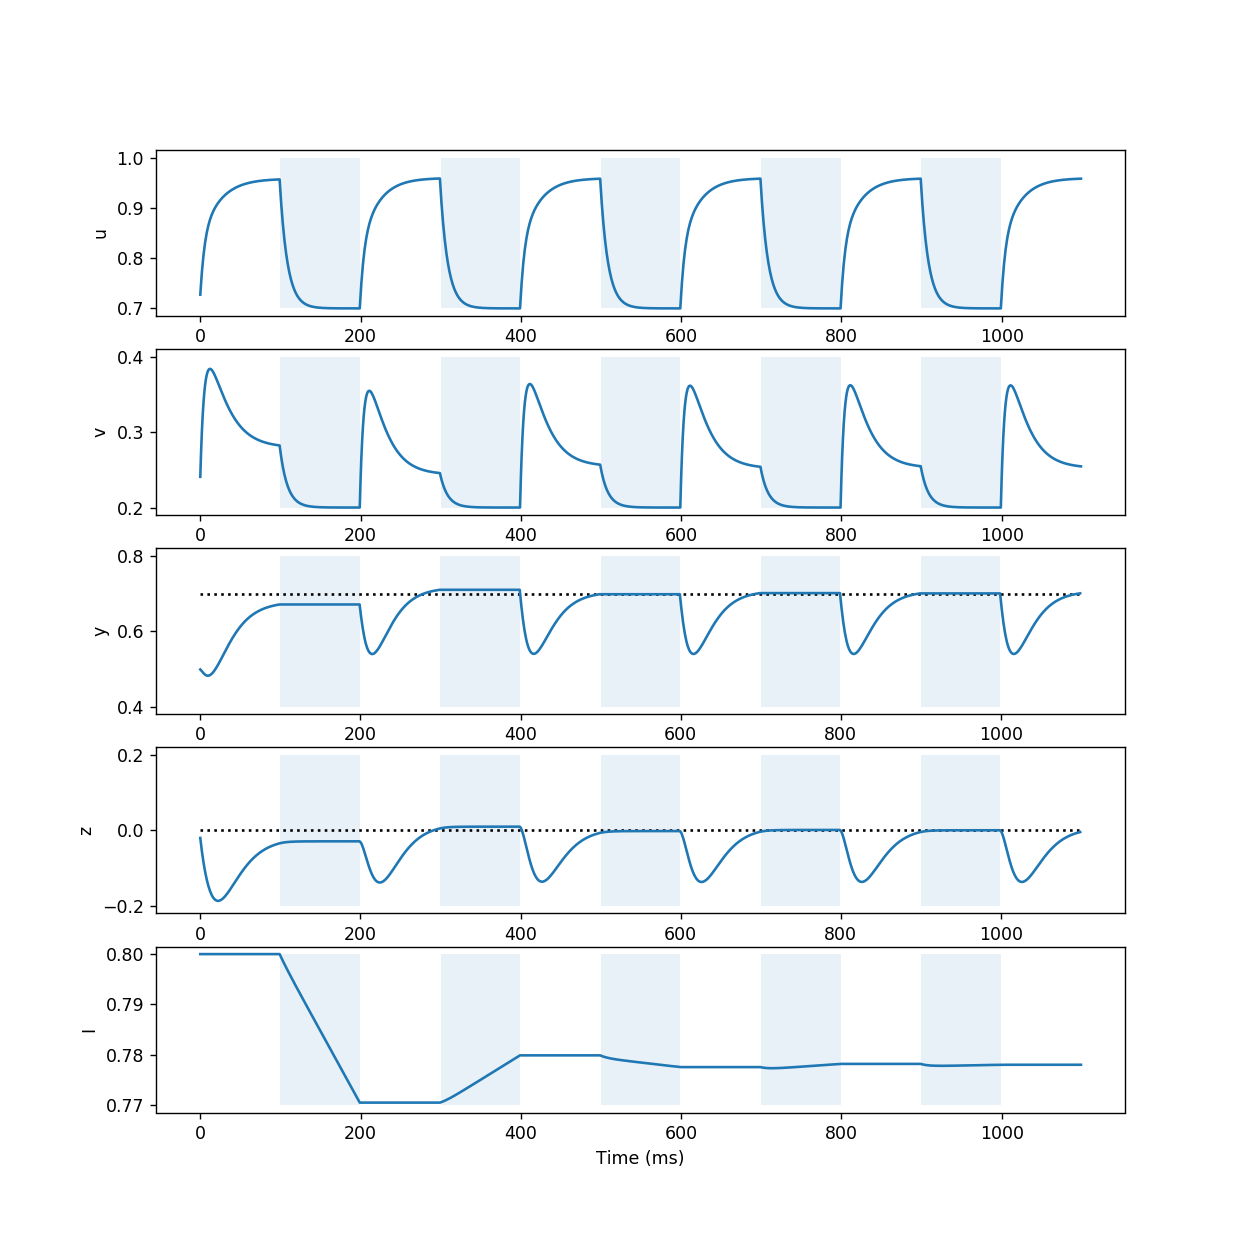

In [13]:
nsteps = len(ulst)
tlst = np.arange(nsteps).astype('int')
sig_lst = np.floor(tlst / 100) % 2
sig_lst = sig_lst.astype('int')

fig, ax = plt.subplots(5, 1, figsize=(10, 10))
ax[0].plot(ulst)
ax[0].set_ylabel('u')
ax[0].fill_between(np.arange(nsteps), 0.7, 1, where=sig_lst, alpha=0.1)

ax[1].plot(vlst)
ax[1].set_ylabel('v')
ax[1].fill_between(np.arange(nsteps), 0.2, 0.4, where=sig_lst, alpha=0.1)

ax[2].plot(ylst)
ax[2].set_ylabel('y')
ax[2].fill_between(np.arange(nsteps), 0.4, 0.8, where=sig_lst, alpha=0.1)
ax[2].hlines(0.7, 0, nsteps, linestyle='dotted')

ax[3].plot(zlst)
ax[3].set_ylabel('z')
ax[3].fill_between(np.arange(nsteps), -0.2, 0.2, where=sig_lst, alpha=0.1)
ax[3].hlines(0.0, 0, nsteps, linestyle='dotted')

ax[4].plot(Ilst)
ax[4].set_ylabel('I')
ax[4].fill_between(np.arange(nsteps), 0.77, 0.8, where=sig_lst, alpha=0.1)
ax[4].set_xlabel('Time (ms)');